In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from cpymad.madx import Madx
import urllib

from IPython.core.display import display, HTML, Markdown

display(HTML("<style>.rendered_html { font-size: 17px; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

def printmd(string):
    display(Markdown(string))

pd.set_option('display.max_rows', None)
plt.ion()
%matplotlib notebook

This notebook shows how the linac to SPS transfer line concept was studied. Note that the result is not perfect has the goal was to validate the concept, investigate possible use of existing magnets available in the CERN storage and evaluate costs. Further study and optimisation is needed for the technical implementation and design step. 

The results of this study were dscussed in a Letter od Intent submitted to the SPS scientific comittee and available [here](https://cds.cern.ch/record/2640784/files/SPSC-EOI-018.pdf)

# TI2 line

Fast extraction from the SPS long straight section 6 tansfers beam to the TT60 tunnel and towards wither the HighRadMAt experimental area or towards the LHC.

 <img src="./ressources/layout_overview.png" style="width: 900px;"/>
 
 
 The concept is as follows
 - an electron linac will be placed in an existing building in the surface, in direct line with the TT60 tunnel, not showed in the figure above it would be far to the left
 - an electron beam transport line will be installed from the linac an connect to one of the existing lines for a fast injection into the SPS ring
 
 Note that in this concept, electrons would circulate opposite to the direction of hadrons. Electrons being negatively charged both direction and charge will be reversed wich means that optics and trajectory of the beam would be the same as for hadrons without needing to reverse any magnetic fields
 
 We will start by loading the stitched SPS+TI2 extraction line optics from the CERN accelerator optics repository [here](https://acc-models.web.cern.ch/acc-models/tls/2021/sps_extraction/tt60ti2_q26/stitched/)

In [143]:
# initialization of the madx cpymad object
madx = Madx()

# loading complete lattices from dumped sequences in the accelerator optics repo
madx.input(urllib.request.urlopen('https://gitlab.cern.ch/acc-models/acc-models-tls/-/raw/7a25318f64d92a40952114ce6dd3009e7d8b910d/sps_extraction/tt60ti2_q26/stitched/jmad/sps_ti2q26_savedseq.seq').read().decode('ascii'))
madx.input(urllib.request.urlopen('https://gitlab.cern.ch/acc-models/acc-models-tls/-/raw/7a25318f64d92a40952114ce6dd3009e7d8b910d/sps_extraction/tt60ti2_q26/stitched/jmad/sps_ti2_q26.inp').read().decode('ascii'))


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2020.12.04 09:25:38      +
  ++++++++++++++++++++++++++++++++++++++++++++
++++++ warning: Both energy and pc specified; pc was ignored.
++++++ warning: Both energy and gamma specified; gamma was ignored.
++++++ warning: Both energy and beta specified; beta was ignored.
++++++ warning: Both energy and bhro specified; brho was ignored.
++++++ warning: implicit element re-definition ignored: bpce.61931
++++++ warning: implicit element re-definition ignored: mdva.61932
++++++ warning: implicit element re-definition ignored: vvfa.61957
++++++ warning: implicit element re-definition ignored: mplh.61996
++++++ warning: implicit element re-definition ignored: lsf.62005
++++++ warning: implicit element re-definition ignored: mdh.62007
++++++ warning: implicit element re-definition ignored:

True

In [144]:
# loading and generating twiss from the SPS towards TI2 (normal direction)
madx.use(sequence='sps_ti2')
twiss_forward = madx.twiss(betx='betx0', bety='bety0', alfx='alfx0', alfy='alfy0', dx='dx0', dpx='dpx0').dframe()

# editting the sequence to reverse it, now goes from the SPS towards the LHC
madx.input("""
INJ_KICKER: HKICKER, L=1, kick:=inj_kicker.kick ;
seqedit, sequence=sps_ti2;
flatten;
reflect;
flatten;
        INSTALL, element=INJ.START, class=MARKER, at=-qda.619.coil->l/2, from=qda.619.coil;
        INSTALL, element=INJ.after.QD, class=MARKER, at=qda.619.coil->l/2, from=qda.619.coil;
        INSTALL, element=INJ_KICKER, at=-INJ_KICKER->l/2-MPLH.61655->l/2-0.1, from=MPLH.61655;
        INSTALL, element=END_SHARE_TI2, class=MARKER, at=-MCIAV.20304->l/2, from=MCIAV.20304; 
flatten ;
ENDEDIT ;
""")

#replacing extraction septa and fast kicker, defined as HKICKER into RBEND to ignore trajectories for now and focus on the optics
madx.elements['rbend'].clone('bend_mse', l=madx.elements['mse'].l, angle='kmse618')
for place in ['32', '37', '52', '57', '72']:
    madx.elements['bend_mse'].clone('bend_mse.618'+place)
    
madx.elements['rbend'].clone('bend_mst', l=madx.elements['mst'].l, angle='kmst617')
for place in ['79', '94']:
    madx.elements['bend_mst'].clone('bend_mst.617'+place)
    
    
madx.elements['rbend'].clone('bend_mke', l=madx.elements['mkes'].l)
for place in ['37', '34', '31']:
    madx.elements['bend_mke'].clone('bend_mke.616'+place, angle='kmke616'+place)
    
    
madx.command.seqedit(sequence='sps_ti2')
for elem in ['mse.61872', 'mse.61857', 'mse.61852', 'mse.61837', 'mse.61832', 'mst.61794', 'mst.61779', 'mke.61637', 'mke.61634', 'mke.61631']:
    madx.command.replace(element=elem, by='bend_'+elem)
madx.command.endedit()

# switching off the extraction bumper magnets
for k in ['kmplh61655', 'kmpsh61402', 'kmpsh42198', 'kmplh41994', 'kmplh41658', 'kmpsh62199', 'kmplh61996']:
    madx.globals[k]=0
    
    
# removing the referential change used to switch from the SPS to the extraction lines referential when extracting
madx.command.seqedit(sequence='sps_ti2')
madx.command.remove(element='change_ref')
madx.command.endedit()


tw = twiss_forward.loc['mciav.20304']

madx.input("""
 EXTRACT, SEQUENCE=sps_ti2, FROM=END_SHARE_TI2, TO=bsrta.51631 NEWNAME=handover_to_sps;
 BEAM, particle=electron, energy=3.5, radiate=False;
""")

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
        10099.8881                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       38.18767047                  0        332.8621723         11.7241358 

             dxrms             xcomax             xcorms                 q2 
       2.399162806       0.2703755432      0.02651125964        38.34955458 

               dq2            betymax              dymax              dyrms 
                 0        274.5792998        3.952630764       0.2357417841 

            ycomax             ycorms             deltap            synch_1 
    0.001403911377    8.148264703e-05                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

           synch_6            

True

Handover point between the existing TI2 line and the new line design is set on the LHC side of **MCIAV.20304** magnet. Not that it is placed before the element after the sequence is reversed. 
Now we can extract and draw the existing optics starting from this point. Note that 
- $\alpha$ and $D'$ will need reversing when going the other direction. 
- by default MADX returns values at the end of elements, using marker with zero length lift any issue related to that

In [147]:


madx.use(sequence='handover_to_sps')
twiss_bw_handover = madx.twiss(betx=tw['betx'], bety=tw['bety'], alfx=-tw['alfx'], alfy=-tw['alfy'], 
                               dx=tw['dx'], dy=tw['dy'], dpx=-tw['dpx'], dpy=-tw['dpy'], 
                               x=tw['x']*0, y=tw['y']*0, px=-tw['px']*0, py=-tw['py']*0, range_='#s/qf.60010')

enter Twiss module
 Found 4 initial orbit vector values from twiss command. 

++++++ table: summ

            length             orbit5               alfa            gammatr 
         918.39688                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       3.153375444                  0        332.8537417        3.991058738 

             dxrms             xcomax             xcorms                 q2 
        1.88893124    1.002891594e-05    5.099394237e-06        3.000845753 

               dq2            betymax              dymax              dyrms 
                 0        266.9715451        3.952634798       0.5075018001 

            ycomax             ycorms             deltap            synch_1 
   1.475725462e-05    5.655749347e-06                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0             

<IPython.core.display.Javascript object>


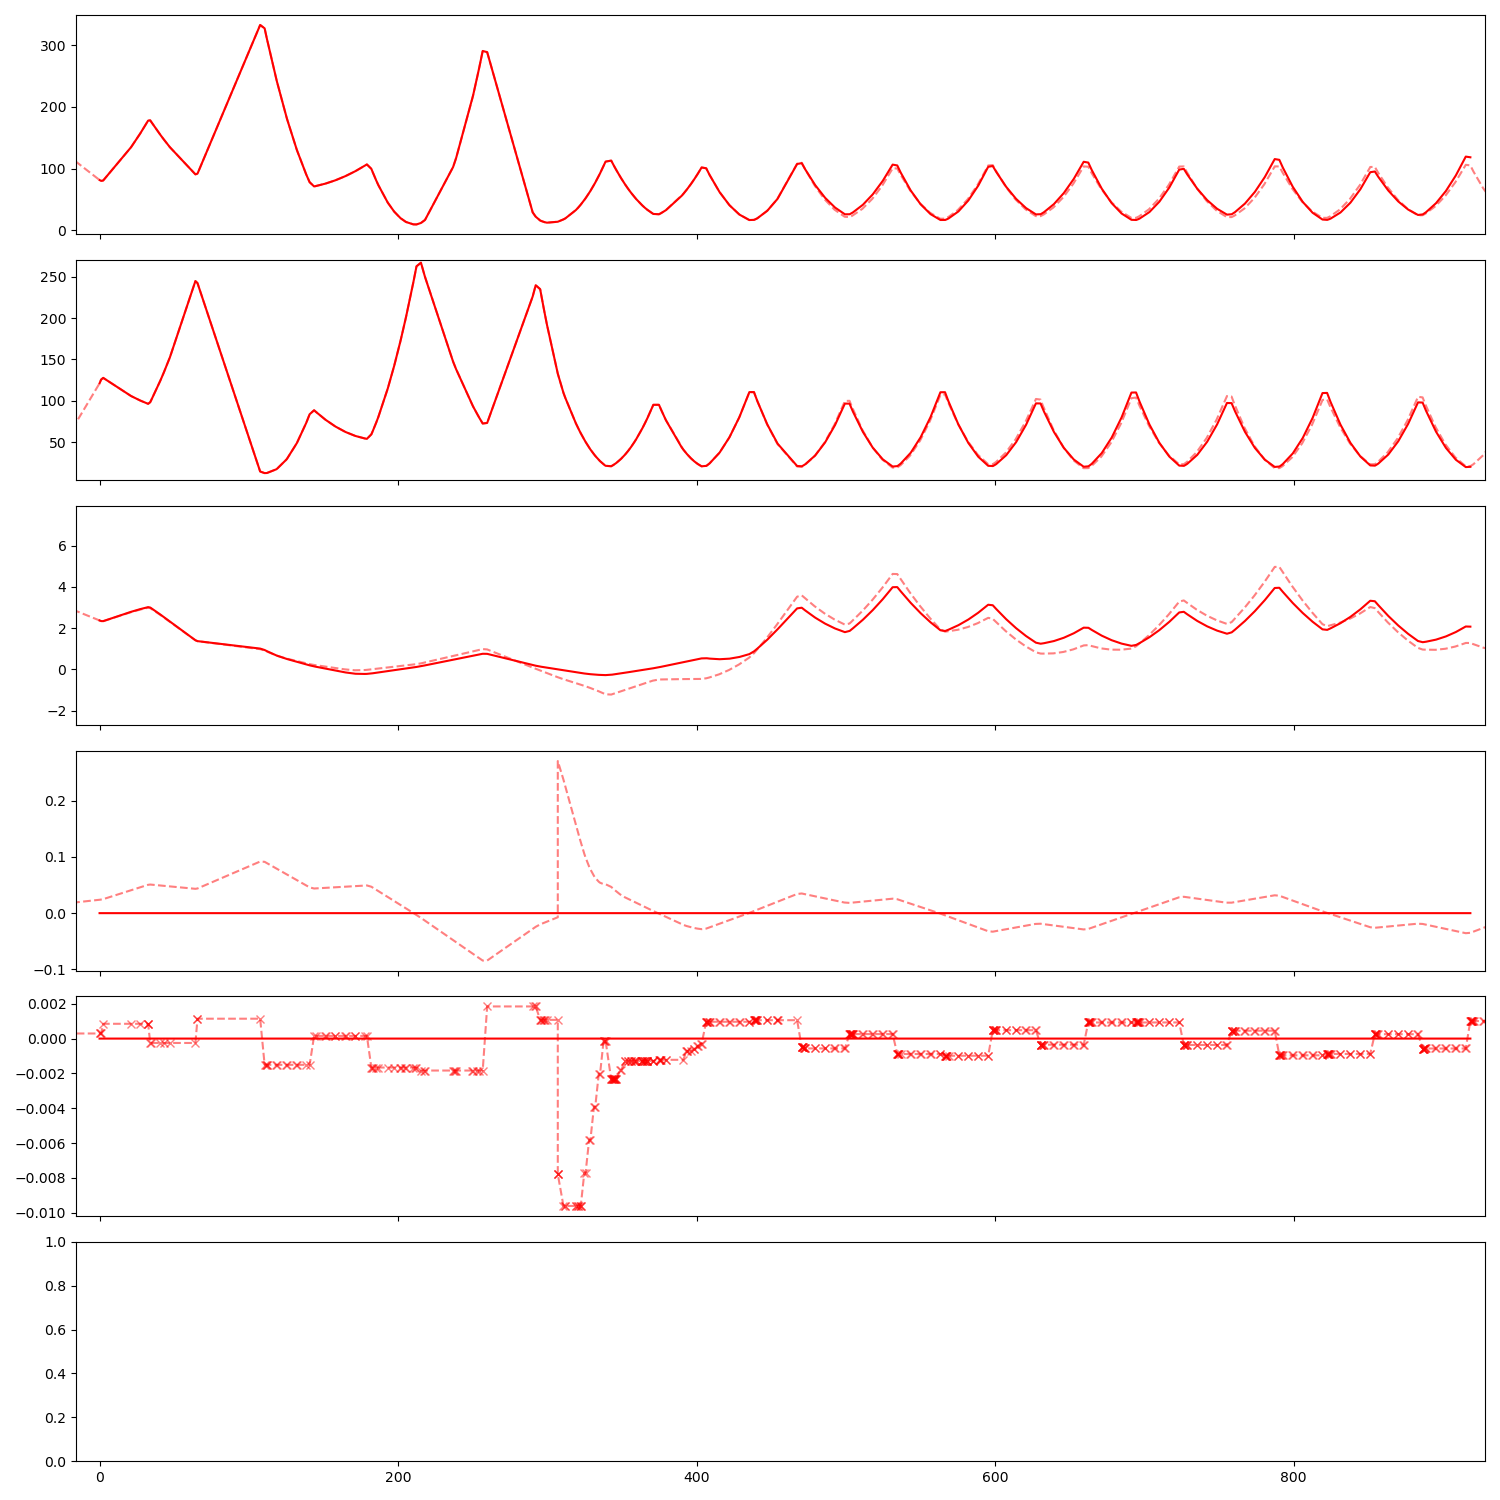

In [148]:
fig, axs  = plt.subplots(6, 1, sharex=True, tight_layout=True, figsize=(15, 15))

_tw = twiss_bw_handover
axs[0].plot(_tw['s'], _tw['betx'], 'r-', label='horizontal')
axs[0].plot(tw['s']-twiss_forward['s'], twiss_forward['betx'], 'r--', alpha=0.5)

axs[1].plot(_tw['s'], _tw['bety'], 'r-', label='horizontal')
axs[1].plot(tw['s']-twiss_forward['s'], twiss_forward['bety'], 'r--', alpha=0.5)

axs[2].plot(_tw['s'], _tw['dx'], 'r-', label='horizontal')
axs[2].plot(tw['s']-twiss_forward['s'], twiss_forward['dx'], 'r--', alpha=0.5)

axs[3].plot(_tw['s'], _tw['x'], 'r-')
axs[3].plot(tw['s']-twiss_forward['s'], twiss_forward['x'], 'r--', alpha=0.5)

axs[4].plot(_tw['s'], _tw['px'], 'r-')
axs[4].plot(tw['s']-twiss_forward['s'], -twiss_forward['px'], 'r--x', alpha=0.5)




In [142]:
twiss_bw_handover.dframe()[['keyword', 's', 'angle', 'x', 'px', 'dx', 'dpx']]

,keyword,s,angle,x,px,dx,dpx
#s,marker,0.000000,0.000,0.000000e+00,0.000000e+00,2.373425,-0.028928
end_share_ti2,marker,0.000000,0.000,0.000000e+00,0.000000e+00,2.373425,-0.028928
mciav.20304,vkicker,0.508000,0.000,0.000000e+00,0.000000e+00,2.358729,-0.028928
drift_0[0],drift,1.038000,0.000,0.000000e+00,0.000000e+00,2.343397,-0.028928
mqid.20300,quadrupole,2.438000,0.000,0.000000e+00,0.000000e+00,2.340121,0.024236
drift_1[0],drift,21.087195,0.000,0.000000e+00,0.000000e+00,2.792097,0.024236
mbidh.20214,rbend,27.287205,0.006,-2.789999e-08,-9.000036e-09,2.960957,0.030236
drift_2[0],drift,32.126410,0.000,-7.145301e-08,-9.000036e-09,3.107274,0.030236
bpmi.20204,monitor,32.376410,0.000,-7.370302e-08,-9.000036e-09,3.114833,0.030236
drift_3[0],drift,32.536410,0.000,-7.514302e-08,-9.000036e-09,3.119670,0.030236


In [76]:
madx.sequence['sps_ti2'].elements['vvsl.51859']

vvsl: instrument, l=0.0;

In [78]:
madx.sequence
tw[['betx', 'bety', 'alfx', 'alfy', 'dx', 'dy', 'dpx', 'dpy']]

betx      81.6232
bety      121.153
alfx    -0.694795
alfy       2.1307
dx        2.37342
dy       -1.26842
dpx     0.0289284
dpy     0.0508181
Name: mciav.20304, dtype: object

In [59]:
twiss_forward.loc['mplh.61655']

name       mplh.61655:1
keyword         hkicker
s                6827.4
betx            59.1811
alfx            1.43164
               ...     
sig63                 0
sig64                 0
sig65                 0
sig66                 0
n1                    0
Name: mplh.61655, Length: 256, dtype: object

In [64]:
list(twiss_forward.index).index('mplh.61655')

3725

In [79]:
print(list(twiss_forward.index))

['#s', 'extrpt_6_start', 'drift_0[0]', 'bpce.61931', 'drift_1[0]', 'mdva.61932', 'drift_2[0]', 'vvfa.61957', 'drift_3[0]', 'mplh.61996', 'drift_4[0]', 'lsf.62005', 'drift_5[0]', 'mdh.62007', 'drift_6[0]', 'bph.62008', 'drift_7[0]', 'qf.62010', 'drift_8[0]', 'mba.62030', 'drift_9[0]', 'mba.62050', 'drift_10[0]', 'mbb.62070', 'drift_11[0]', 'mbb.62090', 'drift_12[0]', 'mpsv.62103', 'drift_13[0]', 'mdv.62107', 'drift_14[0]', 'bpv.62108', 'drift_15[0]', 'qd.62110', 'drift_16[0]', 'mbb.62130', 'drift_17[0]', 'mbb.62150', 'drift_18[0]', 'mpsh.62199', 'drift_19[0]', 'lof.62202', 'drift_20[0]', 'mdh.62207', 'drift_21[0]', 'bph.62208', 'drift_22[0]', 'qf.62210', 'drift_23[0]', 'mba.62230', 'drift_24[0]', 'mba.62250', 'drift_25[0]', 'mbb.62270', 'drift_26[0]', 'mbb.62290', 'drift_27[0]', 'vvsa.62301', 'drift_28[0]', 'mpsv.62303', 'drift_29[0]', 'lsd.62305', 'drift_30[0]', 'mdv.62307', 'drift_31[0]', 'bpv.62308', 'drift_32[0]', 'qd.62310', 'drift_33[0]', 'mbb.62330', 'drift_34[0]', 'mbb.62350', '

In [14]:
tw_zero = twiss_forward[twiss_forward['l']<0.01]
# tw_zero = twiss_forward[twiss_forward['keyword']=='marker']
print(list(tw_zero.index))

['#s', 'extrpt_6_start', 'end.10010', 'begi.10010', 'mdhw.11732', 'mdhw.11737', 'mdhw.11738', 'mdhw.11754', 'tmasc.11802', 'tmasc.11897', 'drift_595[0]', 'drift_918[0]', 'qspl.31809', 'bctw.31931', 'bwsrc.41677', 'bwsrc.41678', 'drift_1244[0]', 'extrpt_4', 'extrpt_4_start', 'bpmea.42172', 'bctdc.51454', 'bctdc.51456', 'bsrta.51631', 'bipmh.51634', 'mdhw.51634', 'mdhw.51637', 'bwsrc.51637', 'bwsrc.51638', 'bipmv.51694', 'drift_1529[0]', 'mdvw.51694', 'mdvw.51696', 'vvsl.51859', 'tmadi.51896', 'tmadi.51901', 'bpmca.61737', 'acfca.61739', 'acfca.61740', 'bpmca.61751', 'drift_1859[0]', 'qspl.61809', 'drift_1881[0]', 'extrpt_6', 'change_ref', 'startti2', 'begline1', 'arcbegin', 'arcend', 'begmatchlhc', 'ti2_lhc_rot', 'msib.entr', 'mki.middle', 'bptx.5l2.b1', 'bpmyb.4l2.b1', 'lhcinj.ti2', '#e']


In [10]:
twiss_forward[['name', 'keyword', 'l']]

,name,keyword,l
#s,sps_ti2$start:1,marker,0.0000
extrpt_6_start,extrpt_6_start:1,marker,0.0000
drift_0[0],drift_0:0,drift,0.2675
bpce.61931,bpce.61931:1,monitor,0.4000
drift_1[0],drift_1:0,drift,0.3090
...,...,...,...
drift_2295[0],drift_2295:0,drift,1.1160
bpmyb.4l2.b1,bpmyb.4l2.b1:1,monitor,0.0000
drift_2296[0],drift_2296:0,drift,0.9940
lhcinj.ti2,lhcinj.ti2:1,marker,0.0000


In [8]:
madx.globals

{'none': 0.0, 'twiss_tol': 1e-06, 'kmdva61932': 0.0, 'kmplh61996': 0.0003791982, 'klsfa': 0.0632564586, 'kmdh62007': 0.0, 'kqf': 0.0144357283, 'kmba': 0.00844514154, 'kmbb': 0.00844514154, 'kmpsv62103': 0.0, 'kmdv62107': 0.0, 'kqd': -0.0144394283, 'kmpsh62199': 0.00015725, 'klof': 0.0, 'kmdh62207': 0.0, 'kmpsv62303': 0.0, 'klsdb': -0.145613182, 'kmdv62307': 0.0, 'klse62402': 0.0, 'kmdh62407': 0.0, 'klsda': -0.149628261, 'kmdv62507': 0.0, 'klsfb': 0.121416689, 'kmdh62607': 0.0, 'klod': 0.0, 'kmdv62707': 0.0, 'kmdh62807': 0.0, 'klqsa': 0.0, 'kmdv62907': 0.0, 'kloe63002': 0.0, 'kmdh63007': 0.0, 'kmdv63107': 0.0, 'kmdh63207': 0.0, 'kmdv63307': 0.0, 'kmdh63407': 0.0, 'kmdv63507': 0.0, 'kloe63602': 0.0, 'kmdh63607': 0.0, 'kmdv10107': 0.0, 'kmdh10207': 0.0, 'klod10302': 0.0, 'kmdv10307': 0.0, 'kloe10402': 0.0, 'kmdh10407': 0.0, 'kmdv10507': 0.0, 'klse10602': 0.0, 'kmdh10607': 0.0, 'kmdv10707': 0.0, 'kmdh10807': 0.0, 'kmdv10907': 0.0, 'kmdh11007': 0.0, 'kmdv11107': 0.0, 'kmdh11207': 0.0, 'kmdv

In [ ]:
|